# Exploring data quality flags

In this notebook, we will explore the numerous data flags that are produced by the LSST stack processing. This is not meant to provide a recommendation about which flags to use, but is rather an illustration of how one can examine the effects of flags on a data set.

(Based in part on notebooks originally written by Angelo Fausti and Sasha Brownsberger)

In [107]:
# LSST stack imports
from lsst.daf.persistence import Butler
import lsst.afw.display as afw_display

# Other python imports
%matplotlib inline
import matplotlib.pyplot as plt
import math
import pandas as pd
import numpy


We'll use results from coadds produced during the HSC weekly reprocessing. See more info here: https://confluence.lsstcorp.org/display/DM/S18+HSC+PDR1+reprocessing

There is currently no convenient way to learn from the butler what dataset types are available, or what tracts, patches, and filters have data. So, we have to know in advance the name of the dataset type (e.g., `deepCoadd_forced_src`), the tract, patch IDs, and filter, which we can get from the wiki page linked above (see also [this summary of HSC-SSP data](https://hsc-release.mtk.nao.ac.jp/doc/index.php/database/)). 

In [108]:
##### If you want to edit the data set, tract, and patch yourself, change the numbers below appropriately
data_set = 'UDEEP'# HSC/SSP survey data include WIDE, DEEP, UDEEP fields
datadir = '/datasets/hsc/repo/rerun/DM-13666/' + data_set 
butler = Butler(datadir)

# We selected the "Ultra-deep (UDEEP)" data, and will choose a tract from the SXDS field (tract 8765):
tract = 8765 #8766
patch = '1,2' #'8,3'  # patch selected at random

#All subsequent data structures will be stored in sets, with the elements of the sets 
# corresponding to the filters you specify here.  So, probably a good idea to remember the order! 
filters = ['HSC-G','HSC-I','HSC-Y'] 
n_filters = len(filters)

# We'll focus our analysis on the forced photometry from the co-add data set:
data_type = 'deepCoadd_forced_src'

Now extract the data for this patch using the butler, looping over the filters defined above:

In [109]:
deep_coadds = [butler.get(data_type, tract = tract, patch = patch, dataId={'filter': filter}) for filter in filters]
n_raw_objects = len(deep_coadds[0])
for i in range(len(filters)):
    print ('Number of objects in filter ' + filters[i] + ' = ' + str(len(deep_coadds[i])))
print ('(Note that those numbers should all be the same.)')

# Convert the catalogs to Astropy tables so we can easily work with them:
deep_coadd_tables = [deep_coadd.asAstropy() for deep_coadd in deep_coadds]

Number of objects in filter HSC-G = 25266
Number of objects in filter HSC-I = 25266
Number of objects in filter HSC-Y = 25266
(Note that those numbers should all be the same.)


What columns are in the catalogs?

In [110]:
table = deep_coadd_tables[0]
table.colnames

['id',
 'coord_ra',
 'coord_dec',
 'parent',
 'deblend_nChild',
 'base_SdssCentroid_x',
 'base_SdssCentroid_y',
 'base_SdssCentroid_xSigma',
 'base_SdssCentroid_ySigma',
 'base_SdssCentroid_flag',
 'base_SdssCentroid_flag_edge',
 'base_SdssCentroid_flag_noSecondDerivative',
 'base_SdssCentroid_flag_almostNoSecondDerivative',
 'base_SdssCentroid_flag_notAtMaximum',
 'base_SdssCentroid_flag_resetToPeak',
 'base_TransformedCentroid_x',
 'slot_Centroid_x',
 'base_TransformedCentroid_y',
 'slot_Centroid_y',
 'base_TransformedCentroid_flag',
 'base_CircularApertureFlux_flag_badCentroid',
 'base_GaussianFlux_flag_badCentroid',
 'base_InputCount_flag_badCentroid',
 'base_LocalBackground_flag_badCentroid',
 'base_PsfFlux_flag_badCentroid',
 'base_SdssCentroid_flag_badInitialCentroid',
 'base_SdssShape_flag_badCentroid',
 'base_Variance_flag_badCentroid',
 'ext_convolved_ConvolvedFlux_0_flag_badCentroid',
 'ext_convolved_ConvolvedFlux_1_flag_badCentroid',
 'ext_convolved_ConvolvedFlux_2_flag_bad

## Exploring data flags in the catalogs:

Here we filter all columns that have 'flag' in their names and get their descriptions.

In [111]:
flags = [ (colname, table[colname].description) for colname in table.colnames if '_flag_' in colname]
pd.DataFrame(flags, columns=['Column Name', 'Description'])

,Column Name,Description
0,base_SdssCentroid_flag_edge,Object too close to edge
1,base_SdssCentroid_flag_noSecondDerivative,Vanishing second derivative
2,base_SdssCentroid_flag_almostNoSecondDerivative,Almost vanishing second derivative
3,base_SdssCentroid_flag_notAtMaximum,Object is not at a maximum
4,base_SdssCentroid_flag_resetToPeak,set if CentroidChecker reset the centroid
5,base_CircularApertureFlux_flag_badCentroid,whether the reference centroid is marked as bad
6,base_GaussianFlux_flag_badCentroid,whether the reference centroid is marked as bad
7,base_InputCount_flag_badCentroid,whether the reference centroid is marked as bad
8,base_LocalBackground_flag_badCentroid,whether the reference centroid is marked as bad
9,base_PsfFlux_flag_badCentroid,whether the reference centroid is marked as bad


Now let's calculate the fraction of objects rejected by each flag:

In [112]:
#tables = [catalog.asAstropy() for catalog in catalogs]

def compute_fraction(table, colname):
    size = len(table)
    fraction = int(len(table[table[colname]==True])/size*100)
    return fraction

fraction_rejected = [[colname] + ["{}%".format(compute_fraction(table, colname)) for table in deep_coadd_tables]
                     for colname, description in flags] 

In [113]:
# Display a table of the fraction of objects rejected by each flag:

df = pd.DataFrame(fraction_rejected, columns=['Flag'] + filters)

# By default, Pandas only displays some rows at the beginning and end. This will force it to display all rows:
with pd.option_context('display.max_rows', None):
    display(df)


,Flag,HSC-G,HSC-I,HSC-Y
0,base_SdssCentroid_flag_edge,3%,3%,3%
1,base_SdssCentroid_flag_noSecondDerivative,0%,0%,0%
2,base_SdssCentroid_flag_almostNoSecondDerivative,4%,3%,3%
3,base_SdssCentroid_flag_notAtMaximum,40%,35%,38%
4,base_SdssCentroid_flag_resetToPeak,1%,2%,1%
5,base_CircularApertureFlux_flag_badCentroid,15%,15%,15%
6,base_GaussianFlux_flag_badCentroid,15%,15%,15%
7,base_InputCount_flag_badCentroid,15%,15%,15%
8,base_LocalBackground_flag_badCentroid,15%,15%,15%
9,base_PsfFlux_flag_badCentroid,15%,15%,15%


## Are there any spatial patterns in the flagged objects?

Select a set of the flags to explore:

In [114]:
flags_to_reject_on = ['base_PixelFlags_flag_bright_objectCenter',
                      'base_PixelFlags_flag_saturated', 
                      'base_PixelFlags_flag_cr',
                      'base_GaussianFlux_flag_badShape',
                      'base_PixelFlags_flag_sensor_edge']

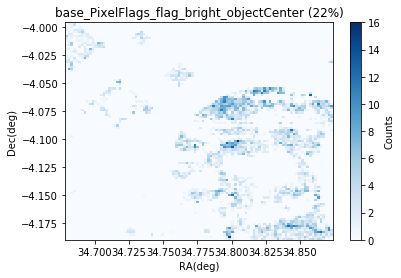

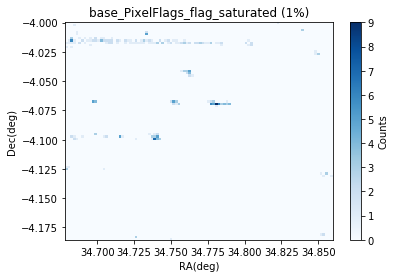

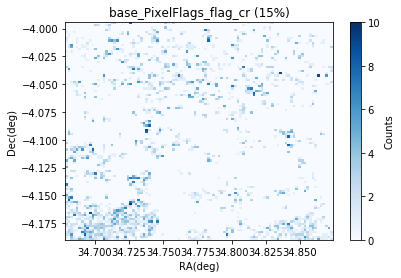

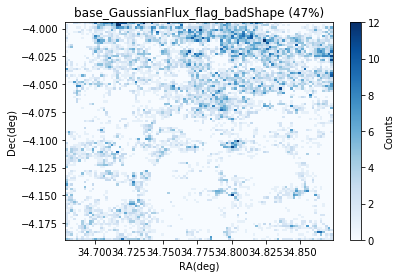

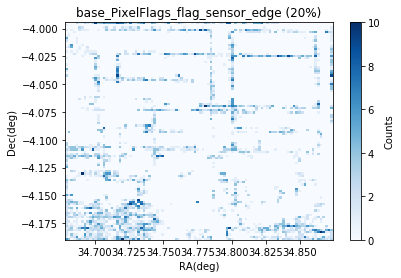

In [115]:
# Plot the spatial distribution of flagged objects in the first filter (in this case, 'HSC-G'):

for flag in flags_to_reject_on:
    index = deep_coadd_tables[0][flag]==True
    plt.figure()
# Note that (RA, Dec) are in radians -- use numpy.rad2deg() to convert to degrees.
    plt.hist2d(numpy.rad2deg(deep_coadd_tables[0]['coord_ra'][index]), numpy.rad2deg(deep_coadd_tables[0]['coord_dec'][index]), bins=(100, 100), cmap='Blues')
    plt.colorbar(label='Counts')
    plt.xlabel('RA(deg)')
    plt.ylabel('Dec(deg)')
    plt.title("{} ({}%)".format(flag, compute_fraction(deep_coadd_tables[0], flag)))
    plt.show()

In [116]:
#Define all possible flags, and our recommended flags 
flags_to_reject_on_recommended= ['base_PixelFlags_flag_bad', 'base_PixelFlags_flag_cr', 'base_PixelFlags_flag_offimage','base_PixelFlags_flag_edge', 'base_PixelFlags_flag_saturated', 'base_PixelFlags_flag_rejected', 'base_PixelFlags_flag_interpolated']
flags_to_reject_on_all = [ (colname, deep_coadd_tables[0][colname].description) for colname in deep_coadd_tables[0].colnames if '_flag_' in colname]
#print (flags_to_reject_on_all)

In [117]:
print ('Choose the flags on which you wish to reject observations. ')
#print ('Here are your options: ')
#print (flags_to_reject_on_all)
#df_allflags = pd.DataFrame(flags_to_reject_on_all, columns=['Column Name', 'Description'])
#with pd.option_context('display.max_rows', None):
#    display(df_allflags)
    
print ('Here are our suggestions:')
print (flags_to_reject_on_recommended)


Choose the flags on which you wish to reject observations. 
Here are our suggestions:
['base_PixelFlags_flag_bad', 'base_PixelFlags_flag_cr', 'base_PixelFlags_flag_offimage', 'base_PixelFlags_flag_edge', 'base_PixelFlags_flag_saturated', 'base_PixelFlags_flag_rejected', 'base_PixelFlags_flag_interpolated']


In [118]:
######ENTER YOUR CHOICE OF REJECTION FLAGS HERE##### 
flags_to_reject_on = [] #Leave empty to use "recommended" flags

# EXAMPLE:
#flags_to_reject_on = ['base_PixelFlags_flag_bright_objectCenter',
#                      'base_PixelFlags_flag_saturated', 
#                      'base_PixelFlags_flag_cr',
#                      'base_GaussianFlux_flag_badShape',
#                      'base_PixelFlags_flag_sensor_edge']

if len(flags_to_reject_on) == 0: 
    flags_to_reject_on = flags_to_reject_on_recommended[:]

In [119]:
#Do operation on all flags in individual filter, and then between filter.  
# So if an object has ANY of the desired flags set, that object will be rejected by the master flag 
total_rej_flags_by_filters = [[any([deep_coadd_table[flag][i] for flag in flags_to_reject_on]) for i in range(n_raw_objects)] 
                                              for deep_coadd_table in deep_coadd_tables] 

for i in range(n_filters):
    nok = len([flag for flag in total_rej_flags_by_filters[i] if flag == False])
    print ('For filter ' + str(filters[i]) + ', ' + str(nok) +\
           ' of ' + str(n_raw_objects) + " ({:.1%})".format((nok/n_raw_objects)) + ' objects were "good" based on your chosen flags.')
 

For filter HSC-G, 17167 of 25266 (67.9%) objects were "good" based on your chosen flags.
For filter HSC-I, 15105 of 25266 (59.8%) objects were "good" based on your chosen flags.
For filter HSC-Y, 10497 of 25266 (41.5%) objects were "good" based on your chosen flags.


### More flags ###

Those aren't the only data flags. There are also flags contained in the "ref" catalogs for each coadd data set. Many of these do not have "flag" in their name, but can be very important. This includes important fields such as "detect_isPrimary" and "base_ClassificationExtendedness_value", among others.


In [120]:
data_type = 'deepCoadd_ref'

deep_coadd_refs = [butler.get(data_type, tract = tract, patch = patch, dataId={'filter': filter}) for filter in filters]

In [121]:
# Convert the catalogs to Astropy tables so we can easily work with them:
deep_coadd_reftables = [deep_coadd_ref.asAstropy() for deep_coadd_ref in deep_coadd_refs]

In [122]:
ref_table = deep_coadd_reftables[0]
ref_table.colnames

['id',
 'coord_ra',
 'coord_dec',
 'parent',
 'merge_footprint_i2',
 'merge_footprint_i',
 'merge_footprint_r2',
 'merge_footprint_r',
 'merge_footprint_z',
 'merge_footprint_y',
 'merge_footprint_g',
 'merge_footprint_N921',
 'merge_footprint_N816',
 'merge_footprint_N1010',
 'merge_footprint_N387',
 'merge_footprint_N515',
 'merge_footprint_sky',
 'merge_peak_i2',
 'merge_peak_i',
 'merge_peak_r2',
 'merge_peak_r',
 'merge_peak_z',
 'merge_peak_y',
 'merge_peak_g',
 'merge_peak_N921',
 'merge_peak_N816',
 'merge_peak_N1010',
 'merge_peak_N387',
 'merge_peak_N515',
 'merge_peak_sky',
 'deblend_nChild',
 'deblend_deblendedAsPsf',
 'deblend_psfCenter_x',
 'deblend_psfCenter_y',
 'deblend_psfFlux',
 'deblend_tooManyPeaks',
 'deblend_parentTooBig',
 'deblend_masked',
 'deblend_skipped',
 'deblend_rampedTemplate',
 'deblend_patchedTemplate',
 'deblend_hasStrayFlux',
 'base_NaiveCentroid_x',
 'base_NaiveCentroid_y',
 'base_NaiveCentroid_flag',
 'base_NaiveCentroid_flag_noCounts',
 'base_Nai

In [133]:
print(np.size(table.colnames))
print(np.size(ref_table.colnames))

492
782


In [241]:
# Filter out the ones with "slot_" in them, since they are simply repeats of the values contained elsewhere:
rr_flags = [ (colname, ref_table[colname].description) for colname in ref_table.colnames if 'slot_' not in colname]
pd.DataFrame(rr_flags[600:650], columns=['Column Name', 'Description'])

,Column Name,Description
0,ext_convolved_ConvolvedFlux_0_3_3_flag_apCorr,set if unable to aperture correct ext_convolve...
1,ext_photometryKron_KronFlux_apCorr,aperture correction applied to ext_photometryK...
2,ext_photometryKron_KronFlux_apCorrSigma,aperture correction applied to ext_photometryK...
3,ext_photometryKron_KronFlux_flag_apCorr,set if unable to aperture correct ext_photomet...
4,ext_convolved_ConvolvedFlux_1_4_5_apCorr,aperture correction applied to ext_convolved_C...
5,ext_convolved_ConvolvedFlux_1_4_5_apCorrSigma,aperture correction applied to ext_convolved_C...
6,ext_convolved_ConvolvedFlux_1_4_5_flag_apCorr,set if unable to aperture correct ext_convolve...
7,base_GaussianFlux_apCorr,aperture correction applied to base_GaussianFlux
8,base_GaussianFlux_apCorrSigma,aperture correction applied to base_GaussianFlux
9,base_GaussianFlux_flag_apCorr,set if unable to aperture correct base_Gaussia...
